In [1]:
import collections
import itertools
from IPython.display import Audio, HTML, display

import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import numpy as np

from chord_progressions.io.audio import combine_buffers
from chord_progressions.utils import is_circular_match
from chord_progressions.type_templates import get_template_from_template_str
from torch.utils.data import DataLoader
from tqdm import tqdm

from rhythmic_relationships.data import PairDataset

from notebook_utils import (
    get_chroma_vocab,
    get_audio_el,
    mk_voiced_chroma_buffer,
    get_voiced_hits_from_chroma,
)

display(HTML("<style>.container { width:90% !important; }</style>"))

## Load the vocabulary

In [2]:
CHROMA_VOCAB = get_chroma_vocab()
inv_vocab = {v: k for k, v in CHROMA_VOCAB.items()}
stoi = {s: i for i, s in enumerate(inv_vocab)}
itos = {i: s for s, i in stoi.items()}
itot = {ix: i for ix, i in enumerate(list(CHROMA_VOCAB))}
ttoi = {v: k for k, v in itot.items()}

vocab_size = len(CHROMA_VOCAB)
print(f"Vocab size: {vocab_size}")

def get_type_from_template(template):
    for chord_type in list(CHROMA_VOCAB):
        if is_circular_match(
            template,
            get_template_from_template_str(CHROMA_VOCAB[chord_type]),
        ):
            return chord_type
    return None

def pclist_to_i(pclist):
    """Gets a chord type index from a pitch class list
    e.g. pclist_to_i([1,0,0,0,0,0,0,0,0,0,0,0]) -> 1
    """
    chord_type = get_type_from_template(pclist)
    if not chord_type:
        chord_type = "oov"
    template_str = CHROMA_VOCAB[chord_type]
    return stoi[template_str]

Vocab size: 19


## Build the dataset

In [3]:
# Load the dataset
dataset_config = {
    "dataset_name": "babyslakh_20_1bar_4res",
    "part_1": 'Guitar',
    "part_2": 'Piano',
    "repr_1": "chroma",
    "repr_2": "chroma",
}

data = PairDataset(**dataset_config)
loader = DataLoader(data, batch_size=1)

# How many chords types do we use to predict the next one?
# Do not change from 3 until the code for constructing the context is written more generally
context_length = 3

X, Y = [], []

for x, y in tqdm(loader):
    # Binarize the chromas
    x = (x > 1).to(torch.int32)[0]
    y = (y > 1).to(torch.int32)[0]

    # fill context with silence
    context = [stoi[CHROMA_VOCAB['silence']]] * context_length

    for xrow, yrow in zip(x, y):
        ixx = pclist_to_i(xrow.tolist())
        ixy = pclist_to_i(yrow.tolist())
        # print(','.join(itot[i] for i in context), '-->', itot[ixy])

        X.append(context)
        Y.append(ixy)

        # Hard-code context to length 3 for now
        # TODO: construct the context more generally
        if len(Y[-2:]) < 2:
            context[1:] = [Y[-1]] + [ixx]
            continue
        context = Y[-2:] + [ixx] # the previous 2 Ys and the current X

        # Generally, try to hold an even amount of each, but hold an extra
        # y if the context has an odd length.
        #   e.g. for context length c
        #     n_ys = c // 2 if c % 2 == 0 else c // 2 + 1
        #     n_xs = c // 2


X = torch.tensor(X)
Y = torch.tensor(Y)
n_examples = X.nelement()
print(f'{n_examples=}')
print(X.shape, Y.shape)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1412/1412 [00:06<00:00, 206.47it/s]

n_examples=67776
torch.Size([22592, 3]) torch.Size([22592])


In [54]:
# Bengio et al has a vocab size of 17k and they embed them in a 30-dimensional space
# Our vocab size is much smaller, so we can use a much smaller embedding space
n_embed = 2
n_hidden = 200
embedding_size = context_length * n_embed

g = torch.Generator().manual_seed(73709238413)

# Initialize an embeddings vector randomly
C = torch.randn((vocab_size, n_embed), generator=g)

W1 = torch.randn((embedding_size, n_hidden), generator=g) * (5/3) / (embedding_size**0.5)
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
for p in parameters:
    p.requires_grad = True
print(f'num total params: {sum(p.nelement() for p in parameters)}')

num total params: 5457


In [55]:
max_steps = 100000
batch_size = 512
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (batch_size,))
    Xb, Yb = X[ix], Y[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concat the vectors

    # linear layer
    hpreact = embcat @ W1

    # BatchNorm layer
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    # Nonlinearity
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.3 if i < 50000 else 0.03
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

print(loss)

      0/ 100000: 2.9256
  10000/ 100000: 0.8660
  20000/ 100000: 0.9378
  30000/ 100000: 0.9261
  40000/ 100000: 0.7416
  50000/ 100000: 0.8573
  60000/ 100000: 0.8643
  70000/ 100000: 0.9019
  80000/ 100000: 0.7609
  90000/ 100000: 0.7738
tensor(0.8213, grad_fn=<NllLossBackward0>)


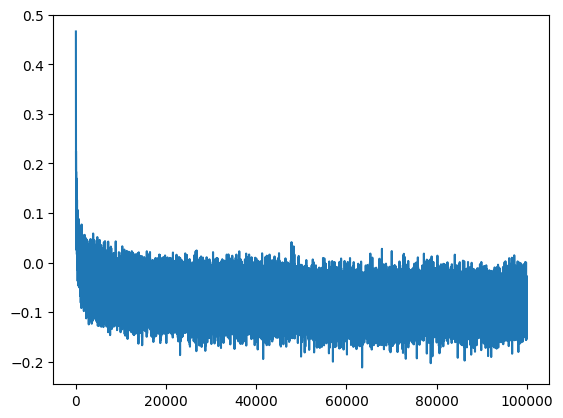

In [56]:
plt.plot(lossi);

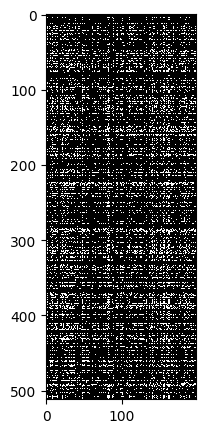

In [57]:
plt.figure(figsize=(5,5))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest');

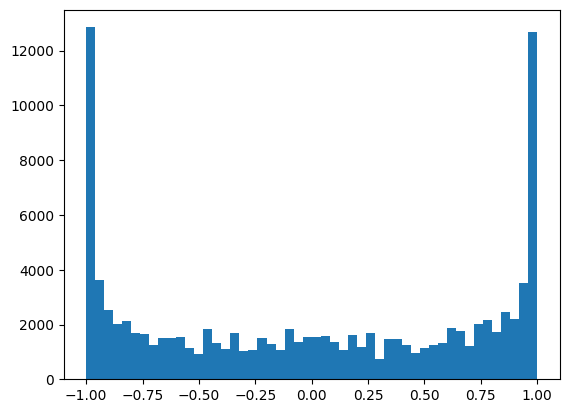

In [58]:
plt.hist(h.view(-1).tolist(), 50);

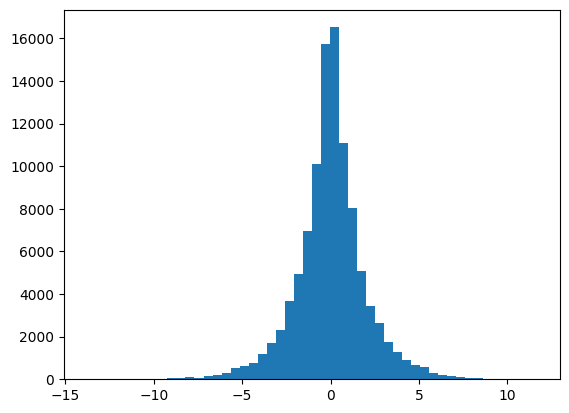

In [59]:
plt.hist(hpreact.view(-1).tolist(), 50);

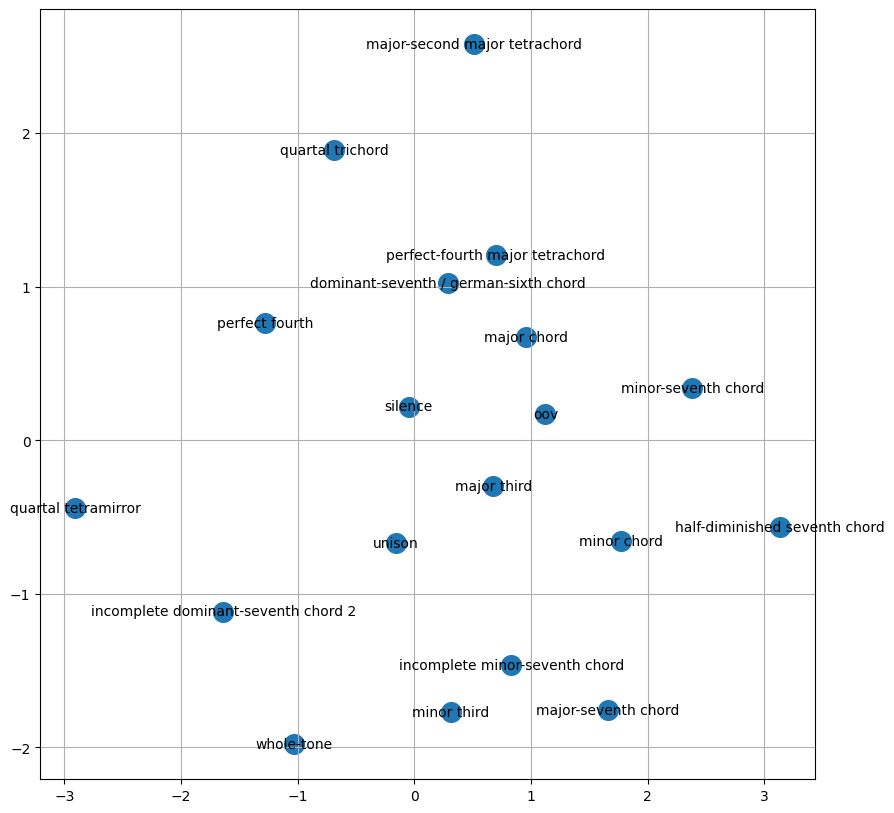

In [62]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(10,10))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itot[i], ha="center", va="center", color='black')
plt.grid('minor')

In [61]:
# sample from the model
g = torch.Generator().manual_seed(73709238413 + 10)

n_samples = 10
duration = 3  # seconds

input_chord_types = [
    "major chord",
    "silence",
    "silence",
    "silence",
    "unison",
    "minor chord",
    "silence",
    "silence",
    "major chord",
    "silence",
    "silence",
    "silence",
    "silence",
    "silence",
    "silence",
    "silence",
]


in_t = [ttoi[''.join(map(str, i))] for i in input_chord_types]

in_chroma = np.array([list(map(int, CHROMA_VOCAB[i])) for i in input_chord_types])
in_voiced_hits = get_voiced_hits_from_chroma(in_chroma)
in_buff = mk_voiced_chroma_buffer(in_voiced_hits, duration=duration, n_overtones=1)
in_hits = (in_chroma.sum(axis=1) > 0).astype(np.int8)

buffs = collections.defaultdict(list)
for _ in range(n_samples):
    out = []

    # We always use the previous 2 Ys and the current X
    context = [stoi[CHROMA_VOCAB['silence']]] * (context_length - 1) + [in_t[0]]

    for tix, t in enumerate(in_t):
        # Forward pass the neural net
        emb = C[torch.tensor([context])] # (1,block_size,n_embed)
        h = torch.tanh(emb.view(emb.shape[0], -1) @ W1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)

        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        out.append(ix)

        # Shift the context window and track the samples
        if len(out[-2:]) < 2:
            # the prev y and the current x
            context[1:] = [out[-1]] + [t]
            continue
        # the prev 2 Ys and the current X
        context = out[-2:] + [t]

    out_chroma = np.array([list(map(int, list(itos[i]))) for i in out])
    out_hits = (out_chroma.sum(axis=1) > 0).astype(np.int8)
    out_voiced_hits = get_voiced_hits_from_chroma(out_chroma)
    out_buff = mk_voiced_chroma_buffer(out_voiced_hits, duration=duration, n_overtones=4)
    buffs["".join(map(str, out_hits))].append([out_buff, combine_buffers([in_buff, out_buff])])

html = (
    f'Input {dataset_config["part_1"]}</br>{"".join(map(str, in_hits))}</br>{get_audio_el(in_buff)}'
    + f'</br></br>Predicted {dataset_config["part_2"]}</br></br>Samples from learned distribution'
    + "".join([f"</br>{k}</br>{get_audio_el(v[0][0])}predicted</br>{get_audio_el(v[0][1])}combined" for k, v in buffs.items()])
)

HTML(html)